# Raw Netcdf: pyfocs single-ended examples

Handling DTS data is an iterative process, often requiring some adjustments to decisions like mapping before the continuous, automated processing can occur. To accommodate this work flow pyfocs includes several functions that can be used to give a quick view of the data.

In this notebook we will look at how some of these decisions, such as number of reference sections to use for calibration vs validation, mapping, and spotting potential issues in the data quality can be done.


In [1]:
import xarray as xr
import pyfocs
import os

/Users/karllapo/anaconda3/lib/python3.7/typing.py:847: FutureWarning: xarray subclass DataStore should explicitly define __slots__
  super().__init_subclass__(*args, **kwargs)


# 1. Load data

## 1.1 Configuration files

- The examples assume they are running within the pyfocs directory.
- pyfocs is built around the configuration that specify how the automated routine is supposed to run. We will grab all of the single-ended configuration files.
- Here we use the `pyfocs.check.config()` function to return a location library as well as details about the calibration. This step allows us to run the diagnostics plots available within pyfocs.


In [2]:
dir_example = os.path.join('../tests/data/')

# Grab a configuration file for the twisted pair pvc fiber and for the stainless steel fiber
config_names = [
    'example_configuration_steelfiber.yml',
    'example_twistedpair_bothwls.yml',
]

cfg_fname = os.path.join(dir_example, config_names[0])
cfg_ss, lib_ss = pyfocs.check.config(cfg_fname, ignore_flags=True)

cfg_fname = os.path.join(dir_example, config_names[1])
cfg_pvc, lib_pvc = pyfocs.check.config(cfg_fname, ignore_flags=True)


## 1.2 Data

- Here we open up the "raw_netcdf" files. These are just the xml files stored in a netcdf format. No transformation or adjustments have been made to the data.
- The first step of any dts set-up is to verify the data integrity, check the reference section integrity, and verify the mapping

In [3]:
ds = xr.open_dataset(os.path.join(dir_example, 'multifiledemo', 'raw_netcdf', 'raw_channel 1_20190722-0000.nc'))

print(ds)

<xarray.Dataset>
Dimensions:            (LAF: 11498, time: 57)
Coordinates:
  * LAF                (LAF) float64 -222.9 -222.6 -222.4 ... 2.699e+03 2.7e+03
  * time               (time) datetime64[ns] 2019-07-22T00:00:03 ... 2019-07-22T00:04:59
Data variables:
    Ps                 (time, LAF) float64 ...
    Pas                (time, LAF) float64 ...
    temp               (time, LAF) float64 ...
    probe1Temperature  (time) float64 ...
    probe2Temperature  (time) float64 ...
Attributes:
    LAF_beg:  -222.866
    LAF_end:  2699.663
    dLAF:     0.254


The netcdf contains the stokes and anti-stokes intensities (`Ps` and `Pas`) and the instrument reported temperature (`temp`). All three data variables are matrices with dimensions labeled by length along fiber (`LAF`) and time (`time`). Other attributes, such as the total fiber length and the spatial resolution are stored as well. The xarray dataset is the container that we use for all further operations in pyfocs.

# 2 Visualize data integrity

## 2.1 Overviews

The first step when working with DTS data is making sure it looks like it should. For this we can use the `overview` plots. The slice of data we are using (5 minutes of data with a 5s time resolution) is too short to truly make use of some of the options, but we include them here for completeness.

### 2.1a Temperature

First is just viewing the time-averaged temperature as a function of length along fiber (LAF).

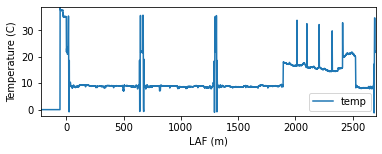

In [4]:
f = pyfocs.dts_plots.overview(
    ds,
    plot_type='temperature',
    temp_field_name='temp')

#### Figure Notes:
This example comes from a complicated example. We had a twisted pair pvc fiber spliced to itself. The first is approximately 0-650m and the second is approximately 650-1305m. Then the twisted pair pvc fibers are spliced to a fiber with a stainless steel jacked. This fiber is heated for segments in order to derive wind speed. The effect of heating can be seen in the elevated temperatures past ~1800m.

---

### 2.1b Estimated instrument noise

Next we can view an estimate of instrument noise as a function of LAF. To do this we employ the Lenschow et al., 2001 method which is commonly used for LIDAR data.

Estimating instrument noise can take some time, especially for longer time slices


/Users/karllapo/anaconda3/lib/python3.7/site-packages/pyfocs/stats.py:50: RuntimeWarning: invalid value encountered in double_scalars
  Sk = np.polyval(p, 0) / var**(3 / 2)


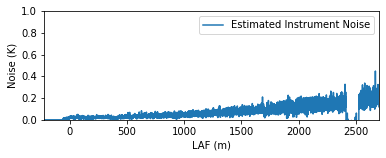

In [5]:
f = pyfocs.dts_plots.overview(
    ds,
    plot_type='noise',
    temp_field_name='temp')



#### Figure Notes:
The method for estimating instrument noise relies on having a robust enough dataset. In this case 5 minutes is too short to really estimate the instrument noise (as exemplified by the negative noise values at the end of the fiber). However, the general idea, that noise increases with distance along the fiber, is evident.

---

### 2.1c Spatial variance in backscattered intensities

Finally, we can view the spatial variances of the power. These are the standard deviation in space along a rolling window that is 10 spatial observations long. This is nominally for spotting potential bend- and step-losses. However, we have found this quantity to not be so useful in our testing.

/Users/karllapo/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


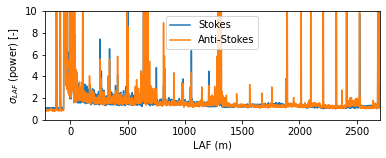

In [6]:
f = pyfocs.dts_plots.overview(
    ds,
    plot_type='variance',
    temp_field_name='temp',
    lims_dict={'variance': [0, 10]})

## 2.2 Reference section integrity

This check is the most critical one, as the values used for the reference section must be well-behaved in order to have a good calibration. Here we look at the reference sections, specifically making sure our boundaries for the reference section make sense and that the baths are well-behaved (flat in power anomaly and instrument reported temperature). 

(3, 12)


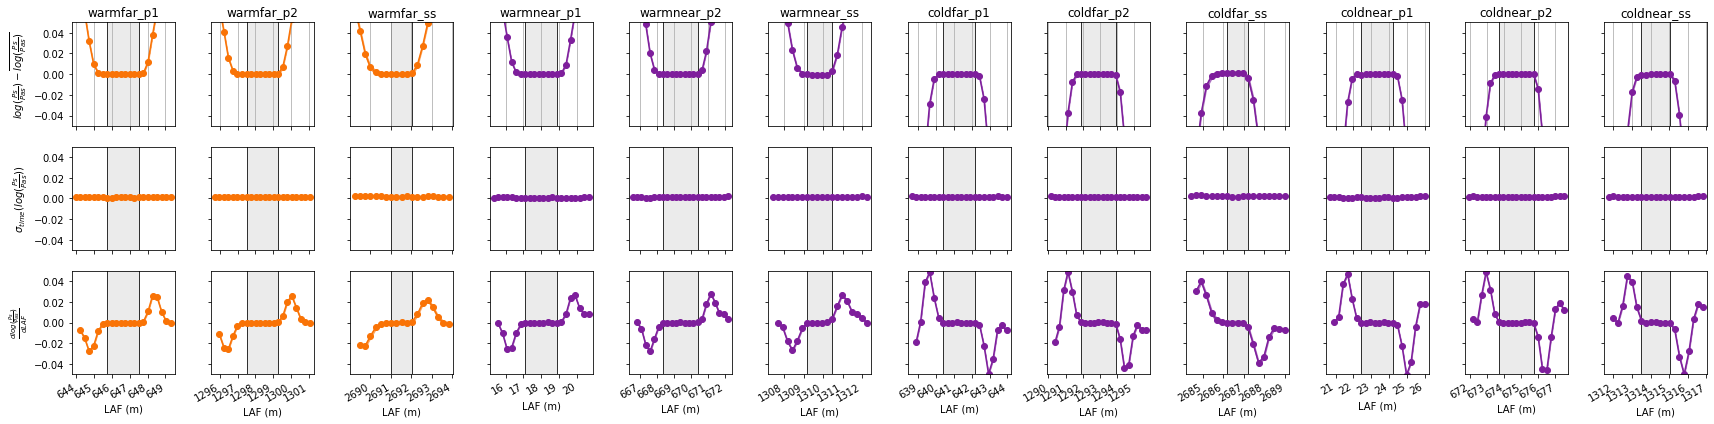

In [7]:
# Here we need to label the reference section locations. We can use the pyfocs labeler to do this
ds = pyfocs.labelLoc_additional(
    ds,
    cfg_pvc['calibration']['library'],
    'calibration')

fig = pyfocs.bath_check(ds, cfg_pvc['calibration']['library'], fig_kwargs={'figsize': (24, 6), 'sharey': True})

##### Figure Notes:

The first row is the _power anomaly_ relative to the mean power within the bath section indicated in grey. The second row is the standard deviation of the power. Over short time intervals this will appear flat, as in the example. Features will appear when examining a longer time slice. The last row is the spatial derivative of the log ratio of power.

The power anomaly and spatial derivative have been the most useful for defining the bath sections. Within the reference sections the power anomaly and spatial derivative should both be flat and very near to zero.

The colors indicate whether the reference section is intended to be used as validation (orange) or in the calibration (purple).

As before, 5 minutes of data is a bit too short for some of this analysis. The bath limits seem to be poor for some of the baths, but this is the result of having too little data and a noisy signal at the end of the fiber (for the stainless steel baths).


# 3 Preparing the section labels

First, we need to verify the data integrity of each section. Here we will be looking speicifically for step- and bend-losses and that the section limits are correct. To do this we need a list of section names. Normally we would need to check each section, but in this case we will just look at a single section as an example.

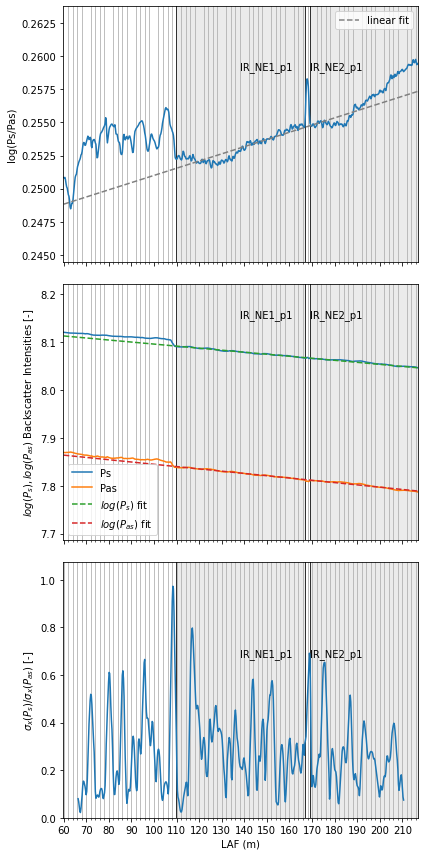

In [8]:
ploc = 'IR_NE1_p1'
f = pyfocs.dts_plots.dts_loc_plot(
    ploc,
    lib_pvc['unheated'],
    ds,
    lin_fit=True,
    offset=50)

As we have already seen a few times, the length of data is too short to truly characterize something like the linearity of $log(\frac{P_s}{P_{as}})$ (top row) or the spatial variance of the backscatter intensities (bottom row).

For longer time periods the impact of temperature variability within a fiber section is limited, leading to much more linear plots than shown here in the top row. However, the power loss that occurs at the fiber holder prior to `IR_NE1_p1` is still visible in the middle plot of $log(P_s)$ and $log(P_{as})$. This quantity should be linear even over 100s of meters.

These plots are useful for adjusting the location library in order to derive the LAF values that represent the section. We normally iterate on these plots multiple times.